# ADT Feature Extraction and Classification Standardization
This Jupyter Notebook is the product of Thomas Hymel. The contents pertain to one part of a Automatic Drum Transcription (ADT) project that I am working on to improve data science and machine learning skills. This notebook in particular focuses on the ADT feature extraction typically used in ADT and audio processing. After that, it focuses on the standardization of the labels used for classifying. Although the *drum piece* labels have already been standardized into a master format by previous code, the classifiers have not been. This is because the amount of classes to aim for could change, so we kept as much information as possible before making that decision. 


### Audio Data Pre-processing and Explanation
There are many models used in ADT but **I am most interested in using convolutional neural networks (CNNs) and perhaps convolutional recurrent neural networks (CRNNs)** as they seem to perform the best in the most recent literature. For CNNs and CRNNs almost always the first step in preprocessing the audio so that features can be properly extracted by the NN is **creating a log mel-spectrogram**. This [blog post here](https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0) explains well what a log mel-spectrogram is, but I will summarize it now, from the beginning of sound, so that I can internally understand it better from its base parts. 

Sound is simply a longitudinal pressure wave, transmitted through vibrations in a medium (usually air). That pressure wave can be measured and characterized as an amplitude as a function of time. Because computer electronics are based around digital objects, a continuous wave (like sound) must be **sampled** to represent it as a discrete sequence of amplitude numbers and store it as a digital object. The *rate* at which a continuous wave is sampled will affect the eventual apparent output shape of that wave. So what *rate* is chosen to sample a wave to make it discrete? Because humans have evolved to hear sound in air for the frequencies between 20 Hz and ~20,000 Hz, we can assume that we don't care about any frequencies above 20,000 Hz. This is our [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist_frequency), so we know we need to sample at >40,000 Hz in order to safely capture all the *frequency* information needed in a discretized sound wave to faithfully recreate it back to a continuous sound wave without humans detecting a difference. The standard audio sampling rate used pretty much everywhere is indeed **44,100 Hz**. Furthermore, in order to properly capture the dynamics of a small and large amplitudes of these pressure waves, the *bit depth* is also often defined (that is, how many different integer numbers you are allowed to use to map the continuous amplitude). The bit depth is pretty much standard at 16 bits (CD quality) or 24 bits (DVD/BluRay audio). 

Digital audio is thus an ordered 1D array of integers, that can, with the properly sampling rate, be converted back to a "continuous" wave and sound through speakers. However, **an ordered 1D array of integers is usually *not* the thing that is fed into a NN directly.** [Note that this case is different from computer vision, where the digital representation of images are often directly fed into NNs (rather than their k-space interpretation).] Any continuous wave object displayed in the time-domain can be transformed using **Fourier series transformations** to have it be represented in the frequency domain, which displays the relative prevelance of the different frequencies within that wave object. The same could be said for discrete wave objects and an appropriately changed Fourier transform function. For ADT and other music information retrieval tasks, the Fourier transform of an *entire song* at once is not that useful, because it doesn't describe the drum events or notes played as a function of time (just as a function of the entire song). If the goal was to know which frequencies occurred in some small time frame, you could slice the song up into tiny frames and *then* do a Fourier transform on *each* of these frames. Indeed, that is exactly what occurs with a [short-time Fourier transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) (STFT). Remember that we are working under the assumption that drum events are "instantaneous" events. Slicing up a song into tiny durations of time, and *then* taking the Fourier transforms of those tiny slices is a reasonable approach to attempting to find "instantaneous" events. In reality, drum events do have some characteristic "duration", so ensuring that your transform slices aren't too *small* for these durations is an important consideration.  

So you now have a representation of the audio, as a function of discrete time steps, for which frequencies occur at (roughly) that specific time. **This representation is called a [spectrogram](https://en.wikipedia.org/wiki/Spectrogram)**, defined as a visual representation of a spectrum of frequencies of a signal as the signal varies with time. On the x-axis is time, the y-axis is the frequencies (in Hz), and then each point on that graph/matrix has a value, and is colored a certain color depending on the prevelance of that frequency, to produce a heat map. A **log spectrogram** is simply representing the y-axis as a log axis (to more accurately represent how humans hear) *and* the color axis on a log axis (to more accurately represent decibels, dB, which is also how humans hear). So what is a **log *mel*-spectrogram?** Well, to *even further* accurately represent how humans hear sound, we can transform the frequency axis (in Hz) into a different unit called mels (short for melody?). The [mel scale](https://en.wikipedia.org/wiki/Mel_scale) is "a perceptual scale of pitches judged by listeners to be equal in distance from one another". This mel scale is effectively a non-linear frequency axis transformation that takes the Hz frequencies and puts them into "equally spaced" bins that are "equal in distance" according to how humans hear them. Once the y-axis has been transformed from Hz to mels, then you are left with a log mel-spectrogram of some audio clip. As a data structure, a mel-spectrogram is a 2D array, where the dimensions are determined by the length of the audio clip (in seconds), the hop length (number of samples between successive frames), the window length (how many samples for each STFT), and the number of mel bins.

#### Log Mel-Spectrogram Exploration
In order to utilize the log mel-spectrogram, a Python package will by imported for the purpose. Here we will use libROSA, which is for music and audio analysis and provides the building blocks necessary to create music information retrieval systems. 

In [1]:
# importing important packages
import numpy as np
import pandas as pd
from pydub import AudioSegment   # main class from pydub package used to upload mp3 into Python and then get a NumPy array
import IPython.display as ipd    # ability to play audio in Jupyter Notebooks if needed

# importing newly relevant packages for log mel-spectrogram exploration
import matplotlib as mpl
import librosa as lb
import librosa.display

test_file = 'may3beta.mp3'
samples_mono, sr = lb.load(test_file, sr=None, mono=True)


# exports the raw data into an array.array object with the format [sample_1_L, sample_1_R, sample_2_L, sample_2_R, ...]
# test_song = AudioSegment.from_mp3(test_file)
# samples = np.array(test_song.get_array_of_samples()).reshape((-1,2))

C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


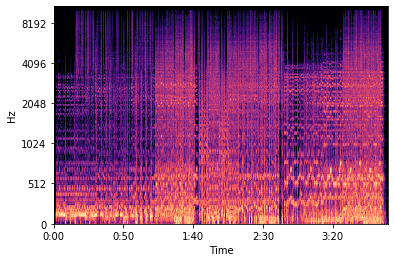

In [3]:
S = lb.feature.melspectrogram(samples_mono, sr=sr, hop_length = 512, n_mels = 250)
S_DB = lb.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis = 'mel')

In [4]:
print(S.shape)
print(4*len(samples_mono)/2048)

(250, 20672)
20671.875


#### Making log mel-spectrograms from MAT dataframes and target labeling considerations
The point of the music-aligned tab dataframes is that I can easily provide a drum piece label to a slice of music, in the hopes that the music/label pairing could potentially be used as an example in a training, development, and/or test set. Well, let's think more deeply about this potential setup, and compare it to previous papers or data sets that utilize spectrograms and CNNs or CRNNs for model building. 

Let's say we already have a model that "works" in the ideal case: that the model takes in a song (and maybe its BPM or other simple information about the song) and outputs a drum tab (either with the measure character or not). In order to properly place the onset of a drum event, the model would need to check sufficiently small slices of the song, just as the training data had fed the model sufficiently small slices of the the training songs. **However there's a potential problem here and it has to do with the "phase" associated with tabbing a song and slicing it the way that I have done.** Currently, given some single 16th note grid event, the song slice associated with that 16th note event starts at the "start" of that 16th note (as determined by the human assigning the first drum note onset) and ends at the beginning of the next 16th note event. This establishes some "phase" of the tab. In fact, an equally valid way to slice the song and assign the drum event labels could be *some amount* of samples starting forward in time, instead of at the "start" of the 16th note grid event, up to half the length of the 16th note resolution. A better way to think about this is to think about what happens when a song gets put into an ideal model. If you slice the song at the wrong "phase" you may never encounter *any* drum event, as determined by the model, because the SFTFs that make up the spectrogram will consistently look *different* to the model than those slices that the model was trained on. The solution to this problem is to make the hop size so small that no matter where the slicing of the song *starts* (to be transformed into STFTs and spectrograms) that a certain slice *will* be captured to appropriately be interpreted by the model as having a drum note onset in it. 

Indeed, this is the case that previous papers describe. For example, in "Drum Transcription via Joint Beat and Drum Modeling Using Convolutional Recurrent Neural Networks" by Vogl et. al., a paper which uses log spectrograms to train RNNs, CNNs, and CRNNs, the window size in the STFTs was 2048 samples, or **46.4 ms** long, and they did this STFT every **10 ms** which is the frame size, and then assigned a drum note onset to one single frame. Checking a song every 10 ms will certainly find a window that entirely contains any potential drum onset in the song. In comparison, for a 150 BPM song, the 16th note grid resolution is 100 ms. Checking every 10 ms, in my opinion, is potentially overkill, but I guess during training and testing I can see what changing that hyperparameter does to the performance of the model. 

So it seems like for training NNs using spectrograms, the target functions are generated by setting frames of a signal with the same frame rate as the input features to the correct class label. Basically you are assigning each hop size (each frame) to a specific label. This practice makes perfect sense to me. The main decision that you need to make is **how many frames do you assign as being "correct"**, and **how long are your window sizes**, and do those two decisions interact with each other? 

I think that I want to do the following: I want to have a song go into the model accompanied by its BPM. (Alternatively, you could use a librosa built-in function to approximate the BPM becasue the exactness doesn't really matter). In this way you can make the STFT window that makes up the spectrogram dependent on the BPM, while the total frame number will *not* be a function of the BPM. For example, if you give it two songs that are each 4 minutes, but one has BPM of 120 and another has BPM of 160, the total number of frames that it will process will be the same because that is only dependent on the hop size and the total duration. However the STFT will yield be different because the window sizes will be different. The point of this is to reflect how the labels are produced: the information of the labels is gathered only based on a BPM basis. That is, the window sizes of the training data itself will be different.

Let's say a song's BPM is 150, so the 16th note resolution would be 15000/150 = 100 ms, which is my current plan for the calculation of the STFT window size. Let's say we have a slice that has some drum event in it. If a STFT has a length of 100 ms, and then we have a hop size of 20 ms (882 samples), that means that *some* part of any one 16th note slice of the song would be contained in (100 ms / 20 ms)x2 = ~10 STFTs. For example, if our 16th note grid slice starts at 350 ms and ends at 450 ms, and our hops are 20 ms along the 20 ms intervals, then the *first* time that a STFT would contain any part of the 16th grid drum event would be at the 260 ms-360 ms STFT slice, with a true overlap ratio of 10% = (360-350)/100. After that, some part of the 16th note drum event would be found in the STFT slices starting at 280 (30%), 300 (50%), 320 (70%), 340 (90%), 360 (90%), 380 (70%), 400 (50%), 420 (30%), and 440 (10%). If this song is being used as a training sample, which of these STFT slices *should* be assigned to a drum event label, and which should not be? The drum events are most likely to be at the beginning of the 16th note duration, although in reality the entirety of the 16th note duration is "useful" to identify the drum event. I probaly will decide that any STFT slice that overlaps some percentage (for example, at least 80%) of the drum note event slice would count as a positive in the label, but this is probably something that I can tinker around with later on. Alternatively, since I am assuming that I am slicing the song at the *beginning* of the drum notes, I could include the one that is closest to the starting time, and a a couple hops before that as well. This method would ensure that for any positive label in the STFT slices, *at least* the beginning of a 16th note slice would be included in that STFT slice. 


### Classification Standardization
At this point we have to do some more processing of the *labels* themselves and decide what the standard classifications should be like. For this to happen we should do processing on the *entire* data set at once, because then we can aggregately identify all the *used* labels and change them into a standardized list. Currently, my plan is to contain the music aligned tab dataframes inside a dictionary, whose keys are the name of the python file and whose values are the music aligned tab dataframe objects. So let's start to write functions to deal with this classification standardization. 

In [160]:
def create_and_describe_FullSetMAT(MAT_dict):
    """
    Function to create, describe and present information to the coder about the labels of the entire data set
    
    Args:
        MAT_dict [dict]: the dictionary whose keys are the python file names of the processed songs and whose values are 
                         the corresponding music aligned tab dataframes
                         
    Returns:
        Dataframe: the FullSet dataframe of all songs' dataframes stacked on top of each other (and outputs information to the user display)
    """
    
    'HARD CODED BLANK_CHAR HERE, USE GETTER FuNCTION INSTEAD TO GRAB THIS VARIABLE'
    blank_char = '-'
    
    # stacks all the dataframes one on top of another in the rows, ignoring indices of each dataframe, and giving each frame an extra "key" layer
    print("...Concatenating all music-aligned dataframes")
    output_df = pd.concat(MAT_dict, axis=0, ignore_index = True, join = 'outer', sort = False)
    
    print("...Replacing NaNs with " + blank_char + " for output")
    output_df = output_df.fillna(blank_char)               # replace NaN with the blank_char
    
    print("...Dropping the song slices \n")
    full_df = output_df.drop(columns = ['song slice'])    # drop the song slice info because we don't care about them right now
    
    print("---fullset.describe() without blank_chars---")
    print(full_df[full_df != blank_char].describe())
    print()
    
    print("Unique values and frequencies in column __:")
    for col in full_df:
        naf_series = full_df[col].value_counts()
        print(str(naf_series.to_frame().T))
        print()
    
    return output_df

In [162]:
# testing the MAT_description function
test_dataset_dict = {maf_song : maf , MAT_df_song : MAT_df}   # creating a test dictionary
FullSet_df = create_and_describe_FullSetMAT(test_dataset_dict)
print(FullSet_df.drop(columns = ['song slice']).describe())

...Concatenating all music-aligned Dataframes
...Replacing NaNs with - for output
...Dropping the song slices 

---fullset.describe() without blank_chars---
          tk    BD   SD   HH  CC   C2   LT   MT  HT   C3
count   4224  1482  644  526  26  282  322  114  78  160
unique     7     1    5    7   3    4    2    2   2    3
top        e     o    o    x   X    X    o    o   o    X
freq    1056  1482  560  340  12  164  304  104  74  148

Unique values and frequencies in column __:
       e     a     +    3    4    2    1
tk  1056  1056  1056  264  264  264  264

       -     o
BD  2742  1482

       -    o   d   r  O  D
SD  3580  560  40  40  2  2

       -    x   w   o   X   O   W  f
HH  3698  340  72  64  22  14  12  2

       -   X   x  b
CC  4198  12  12  2

       -    X    x  b  #
C2  3942  164  110  6  2

       -    o   d
LT  3902  304  18

       -    o   d
MT  4110  104  10

       -   o  d
HT  4146  74  4

       -    X  b  x
C3  4064  148  8  4

          tk    BD    SD   

To clean up the data (that is so cleanly displayed above), and to limit/collapse the classes to fewer number of classes, we want to make a function that we can use to replace the data in our big, entire song dataframe. 

In [145]:
# loading in objects that we saved from a different Jupyter Notebook, for (simplicity currently) and testing purposes
%store -r maf
%store -r MAT_df
%store -r maf_song
%store -r MAT_df_song

#### List of Useful Shortcuts

* Ctrl + shift + P = List of Shortcuts
* Enter (command mode) = Enter Edit Mode (enter cell to edit it)
* Esc (edit mode) = Enter Command Mode (exit cell)
* A = Create Cell above
* B = Create Cell below
* D,D = Delete Cell
* Shift + Enter = Run Cell (code or markdown)
* M = Change Cell to Markdown
* Y = Change Cell to Code
* Ctrl + Shift + Minus = Split Cell at Cursor